<h1>A Transformer Chatbot</h1>

# Import Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import tensorflow as tf
import string
from tensorflow import keras
tf.random.set_seed(1234)
AUTO = tf.data.experimental.AUTOTUNE
import tensorflow_datasets as tfds
import os
import re
import numpy as np
from time import time
import matplotlib.pyplot as plt
import random
import pandas as pd

In [ ]:
# Maximum sentence length
MAX_LENGTH = 15

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 250

# Data Preprocessing

In [ ]:
dataset_chatbot_1 = pd.read_csv("/content/drive/MyDrive/chatbot data.csv")
dataset_chatbot_2 = pd.read_csv("/content/drive/MyDrive/dữ liệu chatbot question-answer short style.csv")

In [ ]:
dataset_chatbot_1.isin(['?']).sum(axis=0)

Unnamed: 0    0
user_a        0
user_b        0
dtype: int64

In [ ]:
dataset_chatbot_2.isin(['?']).sum(axis=0)

Unnamed: 0    0
user_a        2
user_b        2
dtype: int64

In [ ]:
dataset_chatbot_2['user_a'] = dataset_chatbot_2['user_a'].replace('?',np.nan)
dataset_chatbot_2['user_b'] = dataset_chatbot_2['user_b'].replace('?',np.nan)

In [ ]:
dataset_chatbot_1.dropna(inplace=True)
dataset_chatbot_2.dropna(inplace=True)

In [ ]:
questions = []

for data in dataset_chatbot_1['user_a']:
    if "<eos>" in data.split():
        data = data.replace(" <eos> ",", ")
    questions.append(data)

for data in dataset_chatbot_2['user_a']:
    questions.append(data)

print(questions[:5])
print(len(questions))

['bạn tên gì?', 'Tui tên Nam, Bạn học ở đâu?', 'tui học ở TDTU luôn, Bạn học ngành gì', 'Chuyên ngành gì vậy bạn ?', 'mình học Quản Trị Kinh Doanh, Bạn là người ở đâu vậy ?']
7274


In [ ]:
answers = []
for data in dataset_chatbot_1['user_b']:
    if "<eos>" in data.split():
        data = data.replace(" <eos> ",", ")
    answers.append(data)

for data in dataset_chatbot_2['user_b']:
    answers.append(data)

print(answers[:5])
print(len(answers))

['Mình tên Trường, còn bạn tên gì? ', 'tui học ở TDTU nè, còn bạn học ở trường nào ?', 'mình học Công Nghệ Thông Tin', 'mình học bên Kỹ Thuật Phần Mềm á, còn bạn học ngành gì ?', 'Mình là người Đồng tháp, bạn biết Đồng Tháp không ?']
7274


<p>Xây dựng tokenizer (ánh xạ văn bản thành ID và ID thành văn bản) với TensorFlow Datasets SubwordTextEncoder.</p>
<p>Mã hóa từng câu và thêm START_TOKEN và END_TOKEN để cho biết phần đầu và phần cuối của mỗi câu.</p>
<p>Lọc ra các câu có độ dài nhiều hơn MAX_LENGTH </p>
<p>Pad tokenized sentences to MAX_LENGTH</p>
<p>Build tf.data.Dataset with the tokenized sentences</p>

In [ ]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**15)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        # check tokenized sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    # pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [ ]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 6508
Number of samples: 6499


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
print(dataset)

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 15), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 14), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 14), dtype=tf.int32, name=None)})>


# Scaled Dot - Product Attention And Multi-head Attention

<img src="https://3.bp.blogspot.com/-mnlTQLXKuiU/XfgOSZ2eBsI/AAAAAAAAB0w/6jjXEtzO6_M1IlPkNVzR_wcmP62u0jI0ACLcBGAsYHQ/s1600/attention.png" width = "70%">

## Scaled Dot - Product Attention

<h5>Function scaled_dot_product_attention có 3 đầu vào Q (query), K (key), V (value) được sử dụng để tính toán Attention là:</h5>
<img src="https://4.bp.blogspot.com/-JGovZjJGRdU/XfgOi02BVUI/AAAAAAAAB04/hYZsLatBIkE30aYDftH7avQ6dL4KyJ3KgCLcBGAsYHQ/s1600/formula.png" width = "60%">
<h5> Các bước tính toán: </h5>

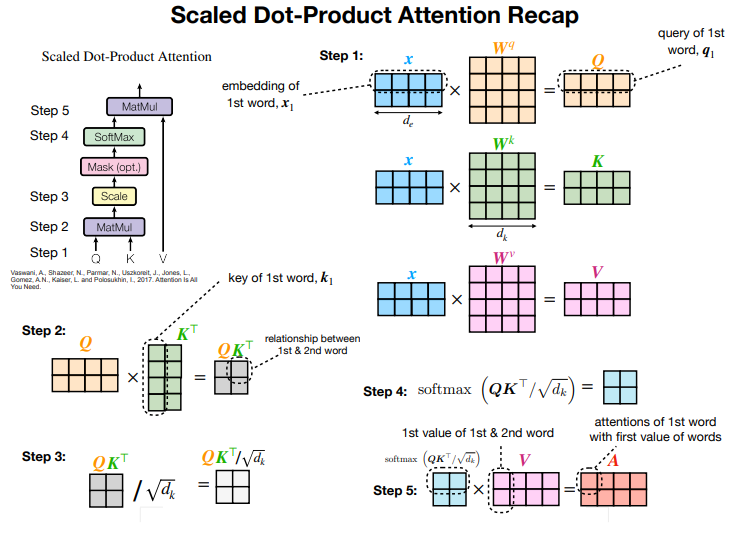



In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

## Multi - Head Attention

Multi-head attention bao gồm 4 phần:
*   Linear layers and split into heads.
*   Scaled dot-product attention.
*   Concatenation of heads.
*   Final linear layer.

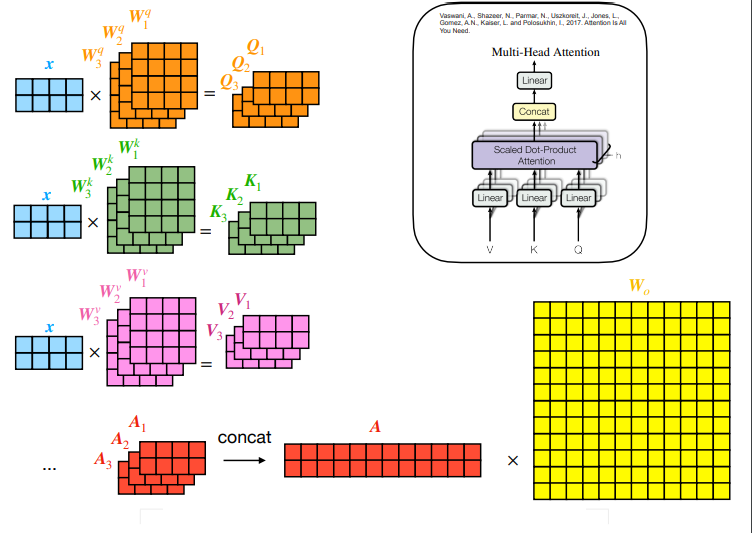






In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)
  
    def get_config(self):
        config = super(MultiHeadAttention,self).get_config()
        config.update({
            'num_heads':self.num_heads,
            'd_model':self.d_model,
        })
        return config

    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(lambda inputs:tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth)))(inputs)
        return tf.keras.layers.Lambda(lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3]))(inputs)

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.transpose(
            scaled_attention, perm=[0, 2, 1, 3]))(scaled_attention)

        # concatenation of heads
        concat_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model)))(scaled_attention)

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs  

# Transformer

<img src ="https://1.bp.blogspot.com/-fud-eRLCZyM/XfgQhgh9KqI/AAAAAAAAB1Q/TWwASlTfimcFVTrvlRBGqm_FtAWfBcYWACLcBGAsYHQ/s1600/transformer.png" width = "50%">

In [ ]:
#create_padding_mask and create_look_ahead are helper functions to creating masks to mask out padded tokens
#we are going to use these helper functions as tf.keras.layers.Lambda layers.
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

## Positional encoding

<p>Vì Transformer không chứa bất kỳ phép lặp lại hoặc tích chập nào, nên Positional encoding được thêm vào để cung cấp cho mô hình một số thông tin về vị trí tương đối của các từ trong câu.</p>

<p>Công thức tính toán mã hóa vị trí như sau:</p>

<img src = "https://2.bp.blogspot.com/-qQM2StMXbnI/XfgQvt0kJwI/AAAAAAAAB1U/vK0l9KdK-1wQWBimKTTxasjRFQSmmylhwCLcBGAsYHQ/s1600/pose.png" width= "50%">


In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
  
    def get_config(self):

        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model,
            
        })
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

## Encoder and Decoder

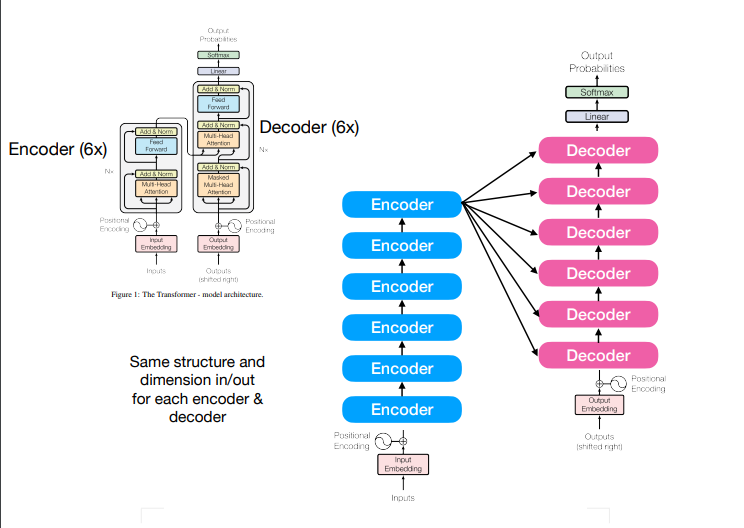

### Encoder Layer

Each encoder layer consists of sublayers:
* Multi-head attention (with padding mask)
* 2 dense layers followed by dropout

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs,attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([attention,outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Encoder 


The Encoder consists of:
* Input Embedding
* Positional Encoding
* N of encoder layers

Đầu vào được đưa qua một embedding được tổng hợp bằng positional encoding. Đầu ra của tổng kết này là đầu vào cho các encoder layer. Đầu ra của encoder là đầu vào cho bộ decoder.

In [ ]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout,name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
    embeddings = PositionalEncoding(vocab_size,d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Decoder_layer


Each decoder layer consists of sublayers:
* Masked multi-head attention (with look ahead mask and padding mask)
* Multi-head attention (with padding mask). value and key receive the encoder output as inputs. query receives the output from the masked multi-head attention sublayer.
* 2 dense layers followed by dropout

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })
    add_attention = tf.keras.layers.add([attention1,inputs])    
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2,attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs,attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### Decoder

The Decoder consists of:
* Output Embedding
* Positional Encoding
* N decoder layers

Mục tiêu được đưa qua một embedding được tổng hợp bằng positional encoding. Đầu ra của phép tổng kết này là đầu vào cho các decoder layers. Đầu ra của bộ giải mã là đầu vào của lớp tuyến tính cuối cùng.

In [ ]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

Transformer bao gồm bộ mã hóa, bộ giải mã và một lớp tuyến tính cuối cùng. Đầu ra của bộ giải mã là đầu vào của lớp tuyến tính và đầu ra của nó được trả về.


In [ ]:
def transformer(vocab_size, num_layers, units, d_model, num_heads,dropout, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

# Training Model

In [ ]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.constant(d_model,dtype=tf.float32)
        self.warmup_steps = warmup_steps
        
    def get_config(self):
            return {"d_model": self.d_model,"warmup_steps":self.warmup_steps}
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.multiply(tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2))

In [ ]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# initialize and compile model within strategy scope

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    2720256     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [ ]:
checkpoint_path = "/content/drive/MyDrive/training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,verbose=1)
model.fit(dataset, epochs=EPOCHS, callbacks = [cp_callback])

Epoch 1/250
102/102 [==============================] - ETA: 0s - loss: 2.8487 - accuracy: 0.0460
Epoch 1: saving model to /content/drive/MyDrive/training/cp.ckpt
102/102 [==============================] - 13s 45ms/step - loss: 2.8487 - accuracy: 0.0460
Epoch 2/250
102/102 [==============================] - ETA: 0s - loss: 2.5308 - accuracy: 0.0714
Epoch 2: saving model to /content/drive/MyDrive/training/cp.ckpt
102/102 [==============================] - 4s 36ms/step - loss: 2.5308 - accuracy: 0.0714
Epoch 3/250
101/102 [============================>.] - ETA: 0s - loss: 2.2686 - accuracy: 0.0714
Epoch 3: saving model to /content/drive/MyDrive/training/cp.ckpt
102/102 [==============================] - 4s 36ms/step - loss: 2.2665 - accuracy: 0.0714
Epoch 4/250
101/102 [============================>.] - ETA: 0s - loss: 2.0942 - accuracy: 0.0714
Epoch 4: saving model to /content/drive/MyDrive/training/cp.ckpt
102/102 [==============================] - 4s 36ms/step - loss: 2.0929 - accuracy

In [ ]:
model.load_weights("/content/drive/MyDrive/training/cp.ckpt")

# Evaluation

In [ ]:
def evaluate(sentence):
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

# Predict

In [ ]:
def predict(sentence):
    prediction = evaluate(sentence)

    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])
    return predicted_sentence

In [ ]:
def removePunctuations(sen):
    temp_l = sen.split()
    i = 0
    j = 0
    for word in temp_l :
        j = 0
        for l in word :
            if l in string.punctuation:
                word = word.replace(l," ")
            j += 1
        temp_l[i] = word.lower()
        i=i+1   
    content = " ".join(temp_l)
    return content

In [ ]:
def chat_with_bot(res=predict):
    GREETING_INPUTS = ["Chào Bot","hi","hey"]
    GREETING_RESPONSES = ["hi", "hey", "hello", "Tôi rất vui, khi bạn muốn trò chuyện với tôi"]
    def greeting(sentence):
        if sentence.lower() in [g.lower() for g in GREETING_INPUTS]:
            return random.choice(GREETING_RESPONSES)

    flag=True
    print("BOT: Tên tôi là Bot. Tôi sẽ trả lời các câu hỏi của bạn về Chatbots. Nếu bạn muốn thoát, hãy nhập Bye!")
    while(flag==True):
        user_response = input()
        user_response=user_response.lower()
        if(user_response!='bye'):
            if(user_response=='cảm ơn' or user_response=='thanks' ):
                flag=False
                print("BOT: Không có gì? Rất vui được trò chuyện với bạn.")
            else:
                 
                if(greeting(user_response)!=None):
                    print("BOT: "+ greeting(user_response))
                else:
                    print("BOT: ", end="")
                    print(res(user_response))
                    
        else:
            flag=False
            print("BOT: Bye!")

In [ ]:
chat_with_bot()

BOT: Tên tôi là Bot. Tôi sẽ trả lời các câu hỏi của bạn về Chatbots. Nếu bạn muốn thoát, hãy nhập Bye!
Bạn quê ở đâu?
BOT: mình quê ở Tiền Giang
Cho mình hỏi quê bạn ở đâu?
BOT: tớ tên Hùng, Phạm Mạnh Hùng
Bạn học ở trường đại học nào?
BOT: trường mình học ở đại học
Bạn học trường nào?
BOT: mình học trường Tôn Đức Thắng
bye
BOT: Bye!


**Tài liệu tham khảo**
<ul>
    <li>https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html</li>
    <li>https://github.com/bryanlimy/tf2-transformer-chatbot</li>
    <li>http://nlp.seas.harvard.edu/2018/04/03/attention.html</li>
    <li>https://buiminhptit.github.io/2020/03/10/gi%E1%BA%A3i-th%C3%ADch-m%C3%B4-h%C3%ACnh-transformer.html</li>
    <li>https://sebastianraschka.com/pdf/lecture-notes/stat453ss21/L19_seq2seq_rnn-transformers__slides.pdf</li>
    <li>https://machinelearningmastery.com/the-transformer-model/</li>
    <li>https://arxiv.org/pdf/1706.03762.pdf</li>
</ul>